<a href="https://colab.research.google.com/github/flororsi/Natural_language_processing/blob/main/Scrapping_analyzing_playstore_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup



In [ ]:
!pip install -qq google-play-scraper

     |████████████████████████████████| 51kB 1.6MB/s 


In [ ]:
!pip install -qq -U watermark

In [ ]:
%reload_ext watermark
%watermark -v -p pandas,matplotlib,seaborn,google_play_scraper

CPython 3.6.9
IPython 5.5.0

pandas 1.1.2
matplotlib 3.2.2
seaborn 0.11.0
google_play_scraper 0.1.1


In [ ]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# Scrapping the information, creating CSV

In [ ]:
app_packages = [
  'com.mcdo.mcdonalds',
  'com.candoit.mostaza',
  'com.grido.app',
  'com.starbucks.ar',
  'ar.burgerking',
]

In [ ]:
app_infos = []

for ap in tqdm(app_packages):
  info = app(ap, lang='es', country='ar')
  del info['comments']
  app_infos.append(info)

100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


In [ ]:
def print_json(json_object):
  json_str = json.dumps(
    json_object, 
    indent=2, 
    sort_keys=True, 
    default=str
  )
  print(highlight(json_str, JsonLexer(), TerminalFormatter()))

In [ ]:
print_json(app_infos[4])

{
  "adSupported": null,
  "androidVersion": "4.4",
  "androidVersionText": "4.4 y versiones posteriores",
  "appId": "ar.burgerking",
  "containsAds": false,
  "contentRating": "Para todos",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "Aplicaci\u00f3n oficial de Burger King\u00ae Argentina para acceder a descuentos y beneficios exclusivos.\r\nDescubr\u00ed la mejor forma de comer tus hamburguesas a la parrilla preferidas a precios \u00fanicos. Eleg\u00ed tu opci\u00f3n ideal, acercate a cualquiera de nuestros locales y prob\u00e1 nuestra famosa Whopper\u00ae o la cl\u00e1sica Stacker\u00ae y acompa\u00f1alas con crujientes papas fritas o con los deliciosos aros de cebolla especialmente empanados.\r\nDisfrut\u00e1 tu comida favorita de Burger King\u00ae sin l\u00edmites.",
  "descriptionHTML": "Aplicaci\u00f3n oficial de Burger King\u00ae Argentina para acceder a descuentos y beneficios exclusivos.<br>Descubr\u00ed la mejor forma de comer tus hamburguesas 

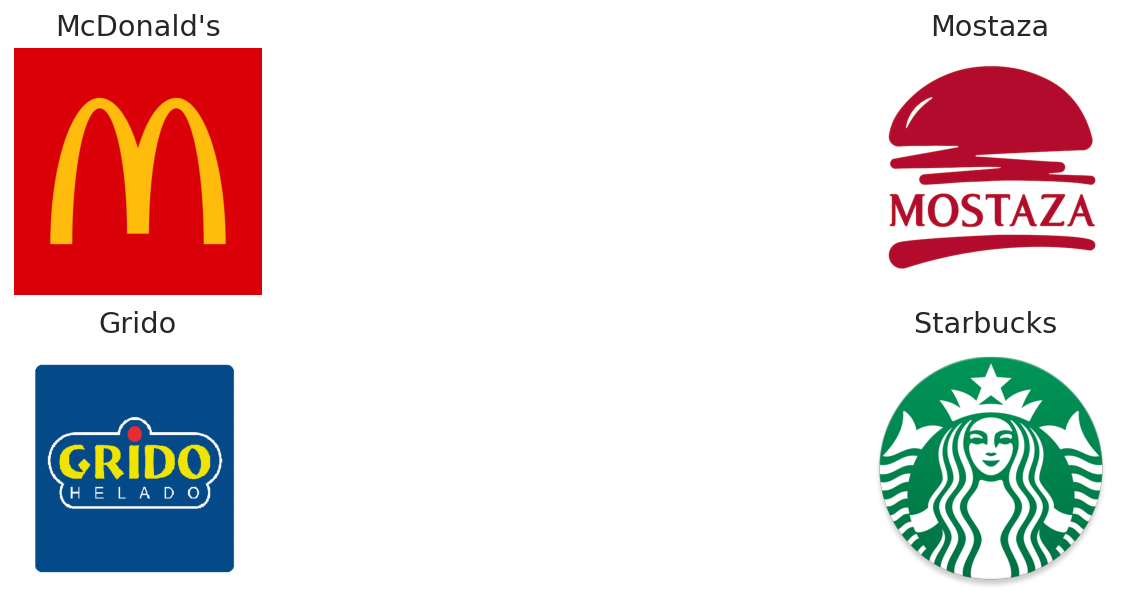

In [ ]:
def format_title(title):
  sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
  if sep_index != -1:
    title = title[:sep_index]
  return title[:10]

fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(14, 5))

for i, ax in enumerate(axs.flat):
  ai = app_infos[i]
  img = plt.imread(ai['icon'])
  ax.imshow(img)
  ax.set_title(format_title(ai['title']))
  ax.axis('off')

In [ ]:
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.to_csv('apps.csv', index=None, header=True)

# Scrapping the reviews

In [ ]:
app_reviews = []

for ap in tqdm(app_packages):
  for score in list(range(1, 6)):
    for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
      rvs, _ = reviews(
        ap,
        lang='es',
        country='ar',
        sort=sort_order,
        count= 200 if score == 3 else 100,
        filter_score_with=score
      )
      for r in rvs:
        r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
        r['appId'] = ap
      app_reviews.extend(rvs)

100%|██████████| 5/5 [00:16<00:00,  3.29s/it]


In [ ]:
print_json(app_reviews[1])

{
  "appId": "com.mcdo.mcdonalds",
  "at": "2020-08-05 12:22:59",
  "content": "Las promociones que ofrecen hoy en d\u00eda son casi sin descuento y en horarios de 15 a 19hs, rid\u00edculo. Para que quiero la app entonces? Sugiero probar con la de Burguer!",
  "repliedAt": null,
  "replyContent": null,
  "reviewCreatedVersion": "2.25.0",
  "reviewId": "gp:AOqpTOFsH4_ixbjCCRNGQWipRcCw0Lg1aqXlYluuRL9n0Dch0Z71D7-g9lh4DCxCz1wToy2hrjub89hTgMz71s8",
  "score": 1,
  "sortOrder": "most_relevant",
  "thumbsUpCount": 182,
  "userImage": "https://lh3.googleusercontent.com/a-/AOh14GgY38C2Wr3QHEn4yVb36kQ4ql2iSjcFmlYiNKwJ1Q",
  "userName": "Sergio T."
}



In [ ]:
len(app_reviews)

4068

In [ ]:
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('reviews.csv', index=None, header=True)

# Review Score - Sentiment

In [ ]:
df = pd.read_csv("reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOFtRu-4OE8m1wL5G2I4Lr1vwZJzO1Hl2hGK2Yh...,Diego NG,https://lh3.googleusercontent.com/a-/AOh14GizH...,Nunca sale mi ciudad y eso que es de las más i...,1,254,2.25.0,2020-08-23 17:06:57,NaN,NaN,most_relevant,com.mcdo.mcdonalds
1,gp:AOqpTOFsH4_ixbjCCRNGQWipRcCw0Lg1aqXlYluuRL9...,Sergio T.,https://lh3.googleusercontent.com/a-/AOh14GgY3...,Las promociones que ofrecen hoy en día son cas...,1,182,2.25.0,2020-08-05 12:22:59,NaN,NaN,most_relevant,com.mcdo.mcdonalds
2,gp:AOqpTOH4yn_SuibRkhOnb7d09CXOoAnK7H7dqa-OuVc...,José Nuñez,https://play-lh.googleusercontent.com/-Vtjb5tU...,Pésima aplicación. Sólo son links que te manda...,1,205,2.25.0,2020-07-31 21:55:11,NaN,NaN,most_relevant,com.mcdo.mcdonalds
3,gp:AOqpTOEn9wbIF-ypnExPOdo9DgXv-JfUbfV9hHPe6Wy...,andrea vega,https://lh3.googleusercontent.com/a-/AOh14GjJ3...,"La aplicación anda mal, por ventana emergente ...",1,11,2.25.0,2020-08-30 16:06:49,NaN,NaN,most_relevant,com.mcdo.mcdonalds
4,gp:AOqpTOGWzyi6d8QO8NO0cwVh1iXfbcbxggGq3c2cFfS...,Jonathan Trujillo Catalán,https://lh3.googleusercontent.com/a-/AOh14GgkH...,Muy malas las promociones. Nada que ver los ho...,1,20,2.25.0,2020-08-12 23:38:26,NaN,NaN,most_relevant,com.mcdo.mcdonalds


In [ ]:
df.shape

(4068, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4068 entries, 0 to 4067
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              4068 non-null   object
 1   userName              4068 non-null   object
 2   userImage             4068 non-null   object
 3   content               4068 non-null   object
 4   score                 4068 non-null   int64 
 5   thumbsUpCount         4068 non-null   int64 
 6   reviewCreatedVersion  3361 non-null   object
 7   at                    4068 non-null   object
 8   replyContent          293 non-null    object
 9   repliedAt             293 non-null    object
 10  sortOrder             4068 non-null   object
 11  appId                 4068 non-null   object
dtypes: int64(2), object(10)
memory usage: 381.5+ KB


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


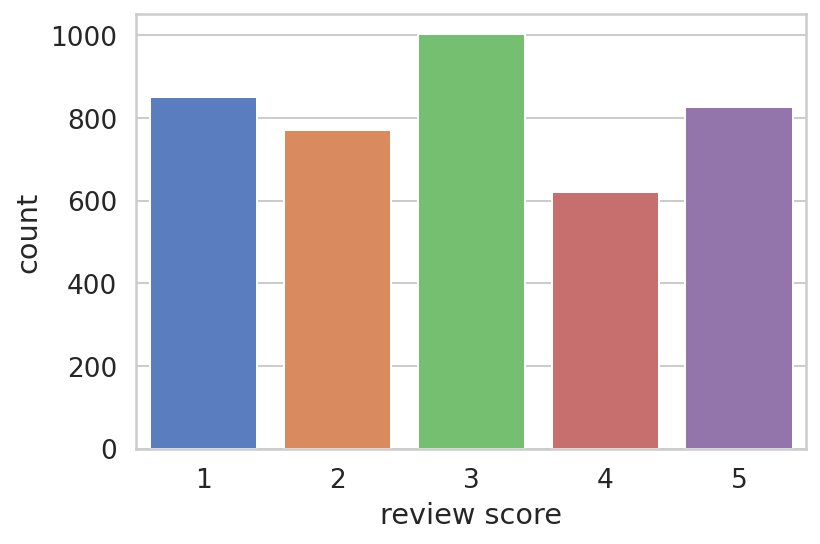

In [ ]:
sns.countplot(df.score)
plt.xlabel('review score');

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


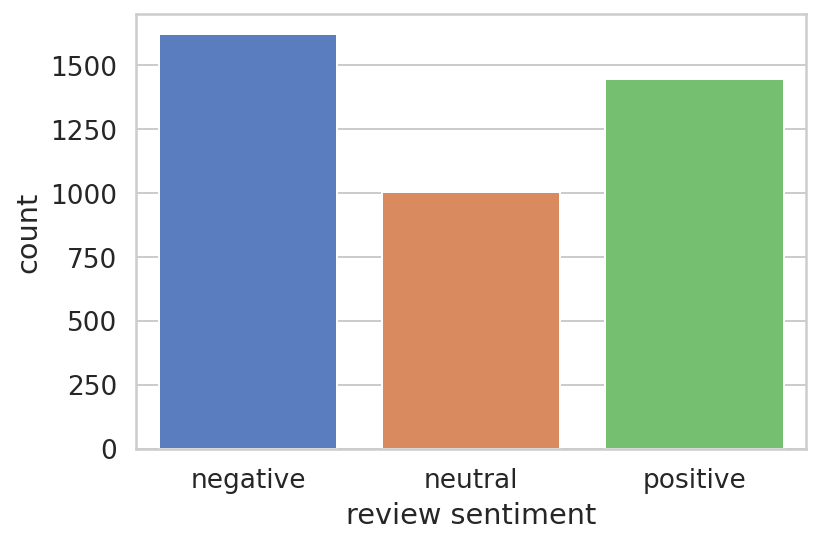

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);


# Data Preprocessing